# Análisis Preliminar de Simulaciones

Después de ejecutar las 10 simulaciones sugeridas, hemos formulado las siguientes hipótesis:

1. **No hay correlación lineal entre los factores ambientales.**
2. **Existe una correlación positiva entre las lecturas térmicas (*thermal readings*) y el éxito de la misión (*mission success*).**
3. **Se observa una correlación positiva entre la densidad poblacional (*population density*) y el éxito de la misión.**
4. **Se requiere más munición (*ammo*) y trajes de radiación (*radiation suits*) en comparación con explosivos (*explosives*).**
5. **El tamaño de las ciudades parece seguir una distribución uniforme.**

Para analizar los datos JSON, utilizaremos Python con las bibliotecas pandas, matplotlib, seaborn y numpy. Vamos a cargar los archivos JSON y realizar análisis específicos para cada una de tus hipótesis.

# Recuerda configurar donde tengas los archivos

In [1]:
%cd /Users/jeronimo/Desktop/Jero/VS_Code/IA/graph_zombie_repo
!pwd

/Users/jeronimo/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/jeronimo/Desktop/Jero/VS_Code/IA/graph_zombie_repo
/Users/jeronimo/Desktop/Jero/VS_Code/IA/graph_zombie_repo


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Cargar los archivos JSON
with open('./data/policies/EvacuationPolicy/experiments/20250303_2205/core_metrics.json', 'r') as f:
    core_metrics = json.load(f)
    
with open('./data/policies/EvacuationPolicy/experiments/20250303_2205/environmental_metrics.json', 'r') as f:
    env_metrics = json.load(f)
    
with open('./data/policies/EvacuationPolicy/experiments/20250303_2205/resource_metrics.json', 'r') as f:
    resource_metrics = json.load(f)


FileNotFoundError: [Errno 2] No such file or directory: './data/policies/EvacuationPolicy/experiments/20250303_2205/core_metrics.json'

In [5]:
with open('/Users/jeronimo/Desktop/Jero/VS_Code/IA/graph_zombie_repo/data/policies/EvacuationPolicy/experiments/20250304_0942/raw_data.json', 'r') as f:
    raw_data = json.load(f)

# Hipótesis 1: No hay correlación lineal entre los factores ambientales
Para verificar esto, podemos crear una matriz de correlación entre todos los indicadores ambientales:

In [4]:
print(env_metrics['by_city_size']["33"]["nodes"])

{'seismic_activity': 0.44417132632598194, 'radiation_readings': 0.38764440943929407, 'population_density': 0.25418663764620064, 'emergency_calls': 0.7195117001435195, 'thermal_readings': 0.41644455363673594, 'signal_strength': 0.589934197478866, 'structural_integrity': 0.5524937112783906}


(31, 13)


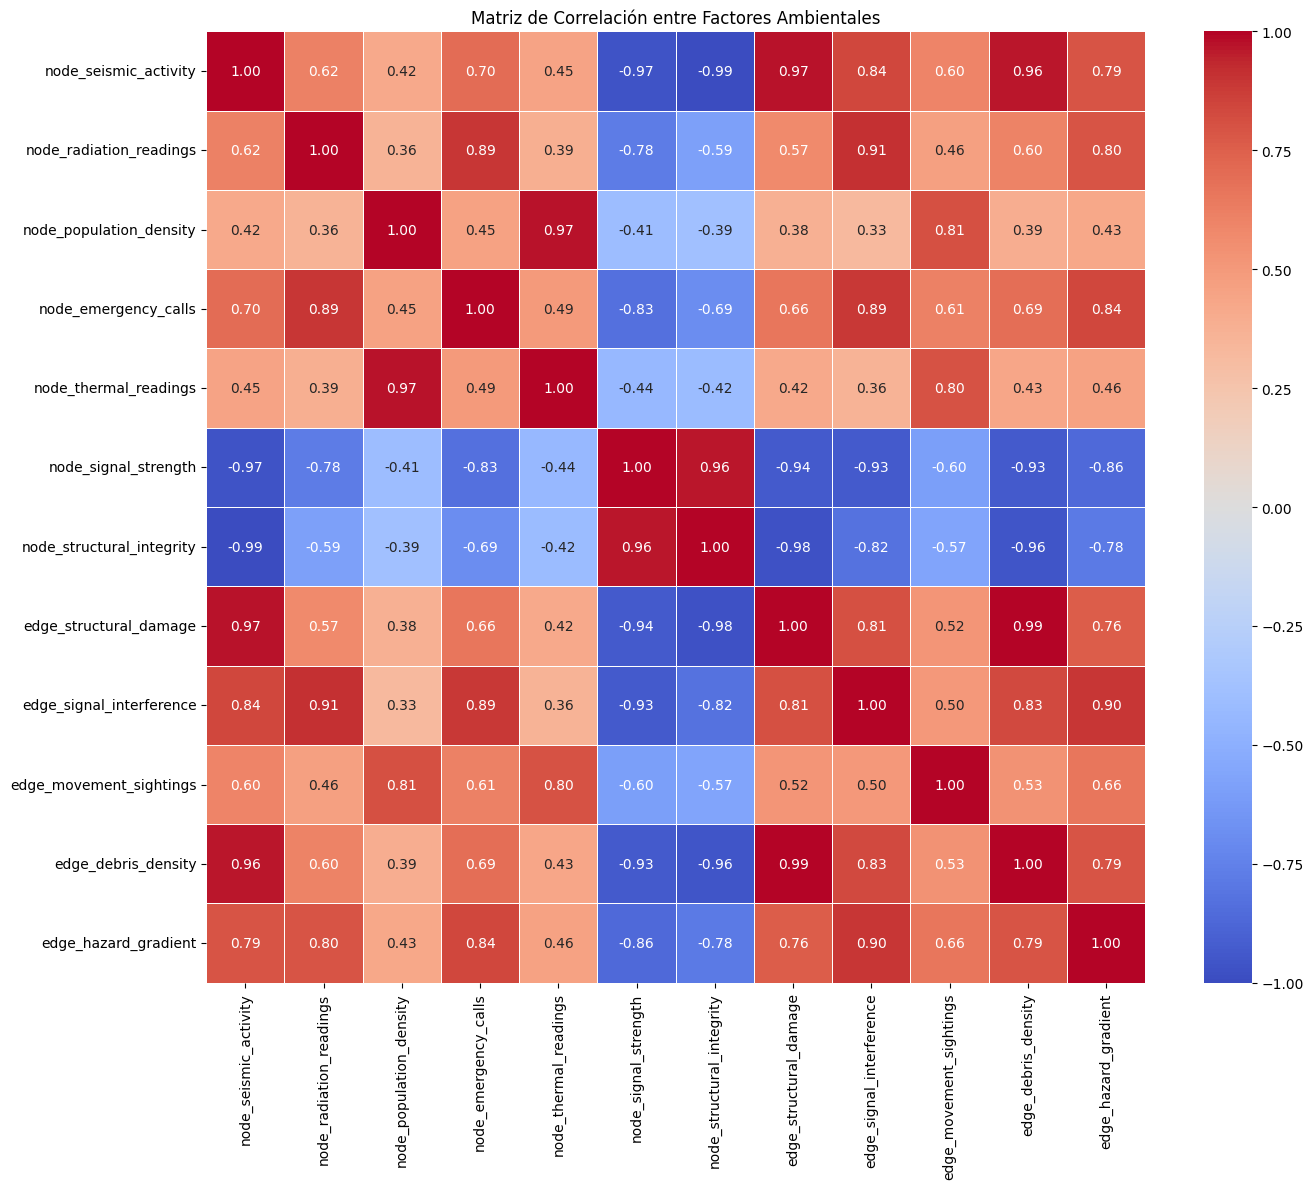

In [5]:
# Extraer los datos de los nodos y aristas
node_indicators = env_metrics['overall']['nodes']
edge_indicators = env_metrics['overall']['edges']

# Combinar ambos tipos de indicadores
all_indicators = {}
for k, v in node_indicators.items():
    all_indicators[f"node_{k}"] = v
for k, v in edge_indicators.items():
    all_indicators[f"edge_{k}"] = v

# Crear un DataFrame para facilitar el análisis
indicators_df = pd.DataFrame([all_indicators])
# Expandir el DataFrame para tener datos por ciudad
city_indicators = []
for size, metrics in env_metrics['by_city_size'].items():
    city_data = {'city_size': int(size)}
    for k, v in metrics['nodes'].items():
        city_data[f"node_{k}"] = v
    for k, v in metrics['edges'].items():
        city_data[f"edge_{k}"] = v
    city_indicators.append(city_data)

city_indicators_df = pd.DataFrame(city_indicators)
print(city_indicators_df.shape)
# Calcular y visualizar la matriz de correlación
plt.figure(figsize=(14, 12))
corr = city_indicators_df.drop('city_size', axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación entre Factores Ambientales')
plt.tight_layout()
plt.show()

# PCA


In [27]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Supongamos que ya tienes tu DataFrame city_indicators_df
# Eliminar la columna 'city_size' ya que no es numérica
data_for_pca = city_indicators_df.drop('city_size', axis=1)

# Aplicar PCA
pca = PCA()  # Por defecto, PCA calcula todos los componentes
pca.fit(data_for_pca)

# Transformar los datos al espacio de componentes principales
transformed_data = pca.transform(data_for_pca)

# Crear un DataFrame con los componentes principales
components_df = pd.DataFrame(transformed_data, columns=[f"PC{i+1}" for i in range(transformed_data.shape[1])])

# Añadir el tamaño de la ciudad si lo necesitas
components_df['city_size'] = city_indicators_df['city_size']

# Ver los componentes principales
print("Componentes principales:")
print(components_df.head())

# Ver la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
print("\nVarianza explicada por cada componente:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f}")

# Ver la varianza acumulada
cumulative_variance = np.cumsum(explained_variance)
print("\nVarianza acumulada:")
for i, var in enumerate(cumulative_variance):
    print(f"PC{i+1}: {var:.4f}")

# Ver las cargas (loadings) de las variables originales en los componentes
loadings = pd.DataFrame(pca.components_, columns=data_for_pca.columns, index=[f"PC{i+1}" for i in range(pca.n_components_)])
print("\nCargas de las variables originales en los componentes principales:")
print(loadings)
cumulative_variance = np.cumsum(explained_variance)
n_components_to_keep = np.argmax(cumulative_variance >= 0.95) + 1  # Conservar componentes hasta el 95%
print(f"\nNúmero de componentes a conservar (95% de varianza): {n_components_to_keep}")

# 2. Seleccionar las cargas de los componentes más importantes
important_loadings = loadings.iloc[:n_components_to_keep, :]

# 3. Identificar las variables más importantes en cada componente
threshold = 0.5  # Umbral para considerar una carga como "alta"
important_variables = set()

for i in range(n_components_to_keep):
    print(f"\nVariables importantes en PC{i+1}:")
    pc_loadings = important_loadings.iloc[i]
    # Seleccionar variables con cargas absolutas mayores al umbral
    significant_vars = pc_loadings[abs(pc_loadings) > threshold]
    print(significant_vars)
    # Añadir estas variables al conjunto de variables importantes
    important_variables.update(significant_vars.index)

# 4. Mostrar las variables más importantes
print("\nVariables más importantes para conservar:")
print(important_variables)

Componentes principales:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.040517  0.001812 -0.064903 -0.007984 -0.012706 -0.012393  0.006093   
1  0.215966 -0.009602 -0.061155  0.023245  0.001579 -0.003464 -0.001751   
2  0.006235  0.028633  0.009260 -0.004752  0.022074 -0.008589  0.007072   
3  0.056456  0.007073 -0.002784  0.022720  0.007145  0.016426 -0.001540   
4 -0.071123 -0.081022 -0.034499 -0.027957 -0.010412  0.003201 -0.006904   

        PC8       PC9      PC10      PC11      PC12  city_size  
0  0.002113 -0.002282  0.001630  0.003209 -0.000285         33  
1  0.003037 -0.000547  0.002948  0.002713  0.002397         47  
2  0.000600 -0.003887 -0.004184  0.000668 -0.005978         50  
3 -0.007972 -0.001129 -0.001114  0.004059  0.001195         48  
4 -0.006001 -0.005271 -0.001626  0.000153  0.000492         29  

Varianza explicada por cada componente:
PC1: 0.7762
PC2: 0.1204
PC3: 0.0676
PC4: 0.0176
PC5: 0.0078
PC6: 0.0060
PC7: 0.0015
PC8: 0.00

In [26]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Supongamos que ya tienes tu DataFrame city_indicators_df
# Seleccionar solo las variables de interés
variables_interes = [
    'node_seismic_activity',
    'node_structural_integrity',
    'edge_debris_density',
    'edge_structural_damage'
]

# Filtrar el DataFrame para incluir solo las variables de interés
data_interes = city_indicators_df[variables_interes]

# Aplicar PCA
pca = PCA()  # Por defecto, PCA calcula todos los componentes
pca.fit(data_interes)

# Transformar los datos al espacio de componentes principales
transformed_data = pca.transform(data_interes)

# Crear un DataFrame con los componentes principales
components_df = pd.DataFrame(transformed_data, columns=[f"PC{i+1}" for i in range(transformed_data.shape[1])])

# Ver los componentes principales
print("Componentes principales:")
print(components_df.head())

# Ver la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
print("\nVarianza explicada por cada componente:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f}")

# Ver la varianza acumulada
cumulative_variance = np.cumsum(explained_variance)
print("\nVarianza acumulada:")
for i, var in enumerate(cumulative_variance):
    print(f"PC{i+1}: {var:.4f}")

# Ver las cargas (loadings) de las variables originales en los componentes
loadings = pd.DataFrame(pca.components_, columns=data_interes.columns, index=[f"PC{i+1}" for i in range(pca.n_components_)])
print("\nCargas de las variables originales en los componentes principales:")
print(loadings)

# Identificar las variables más importantes en cada componente
threshold = 0.5  # Umbral para considerar una carga como "alta"
important_variables = set()

for i in range(pca.n_components_):
    print(f"\nVariables importantes en PC{i+1}:")
    pc_loadings = loadings.iloc[i]
    # Seleccionar variables con cargas absolutas mayores al umbral
    significant_vars = pc_loadings[abs(pc_loadings) > threshold]
    print(significant_vars)
    # Añadir estas variables al conjunto de variables importantes
    important_variables.update(significant_vars.index)

# Mostrar las variables más importantes
print("\nVariables más importantes entre las seleccionadas:")
print(important_variables)

Componentes principales:
        PC1       PC2       PC3       PC4
0 -0.056460 -0.012920 -0.003088  0.000557
1  0.143889 -0.008234 -0.002945  0.003501
2  0.016365  0.009080 -0.004354 -0.007917
3  0.045910  0.007993  0.001397  0.003011
4 -0.099036  0.008890 -0.009581  0.003928

Varianza explicada por cada componente:
PC1: 0.9824
PC2: 0.0145
PC3: 0.0023
PC4: 0.0007

Varianza acumulada:
PC1: 0.9824
PC2: 0.9969
PC3: 0.9993
PC4: 1.0000

Cargas de las variables originales en los componentes principales:
     node_seismic_activity  node_structural_integrity  edge_debris_density  \
PC1              -0.519311                   0.558426            -0.437841   
PC2              -0.413462                   0.484095             0.640186   
PC3               0.709767                   0.572791             0.245733   
PC4               0.235787                   0.354574            -0.581439   

     edge_structural_damage  
PC1               -0.476206  
PC2                0.429956  
PC3             

# Hipótesis 2: Correlación positiva entre thermal readings, population density y mission success

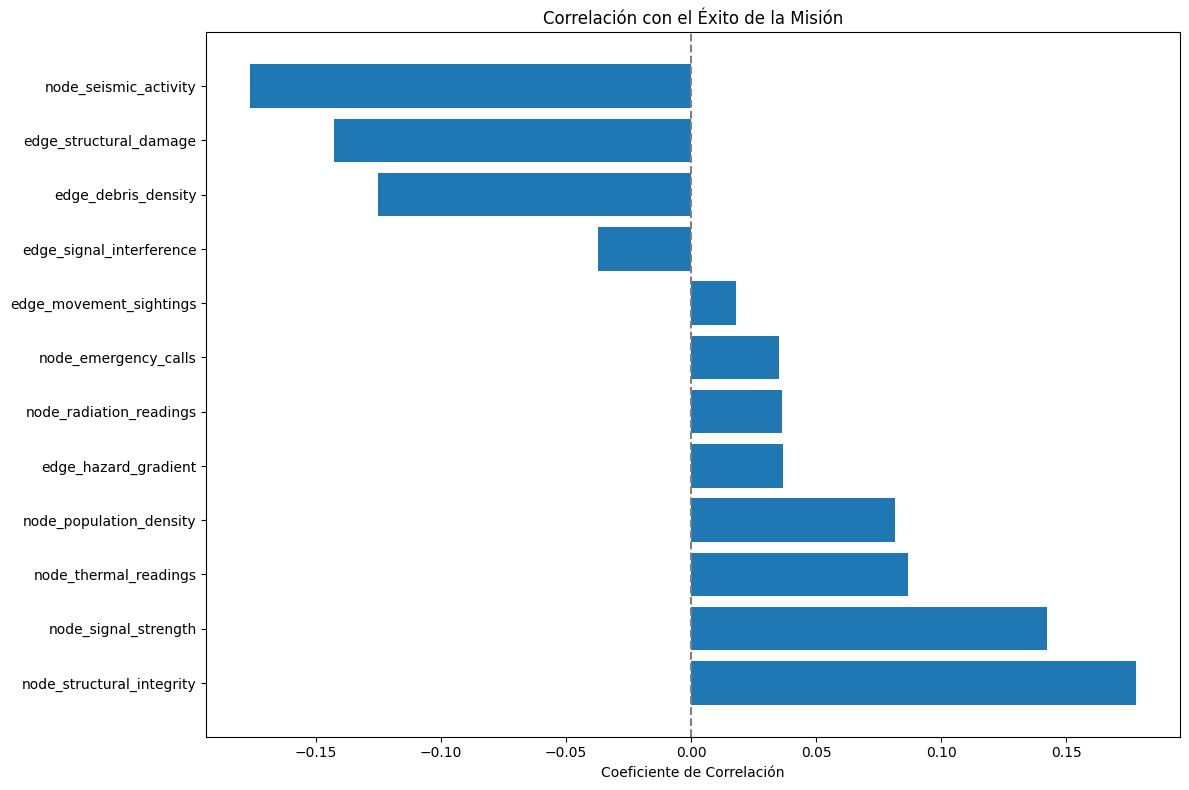

Correlaciones clave con éxito de la misión:
node_thermal_readings: 0.0867
node_population_density: 0.0816


In [6]:
# Extraer las correlaciones con el éxito de la misión
success_correlations = {
    **{f"node_{k}": v for k, v in env_metrics['correlations']['nodes'].items()},
    **{f"edge_{k}": v for k, v in env_metrics['correlations']['edges'].items()}
}

# Ordenar por valor de correlación
sorted_correlations = sorted(success_correlations.items(), key=lambda x: x[1], reverse=True)

# Visualizar las correlaciones
plt.figure(figsize=(12, 8))
indicators, values = zip(*sorted_correlations)
plt.barh(indicators, values)
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Correlación con el Éxito de la Misión')
plt.xlabel('Coeficiente de Correlación')
plt.tight_layout()
plt.show()

# Enfoque específico en thermal_readings y population_density
key_indicators = ['node_thermal_readings', 'node_population_density']
print("Correlaciones clave con éxito de la misión:")
for indicator in key_indicators:
    key = indicator.split('_', 1)[1]  # Eliminar el prefijo "node_"
    corr = env_metrics['correlations']['nodes'][key]
    print(f"{indicator}: {corr:.4f}")

Preguntarle a chat que son realmente los valores que hay dentro de environmental_metrics

# Hipótesis 3: Se necesitan más ammo y radiation_suits que explosives

In [7]:
print(resource_metrics['overall'].keys())

dict_keys(['explosives', 'ammo', 'radiation_suits'])


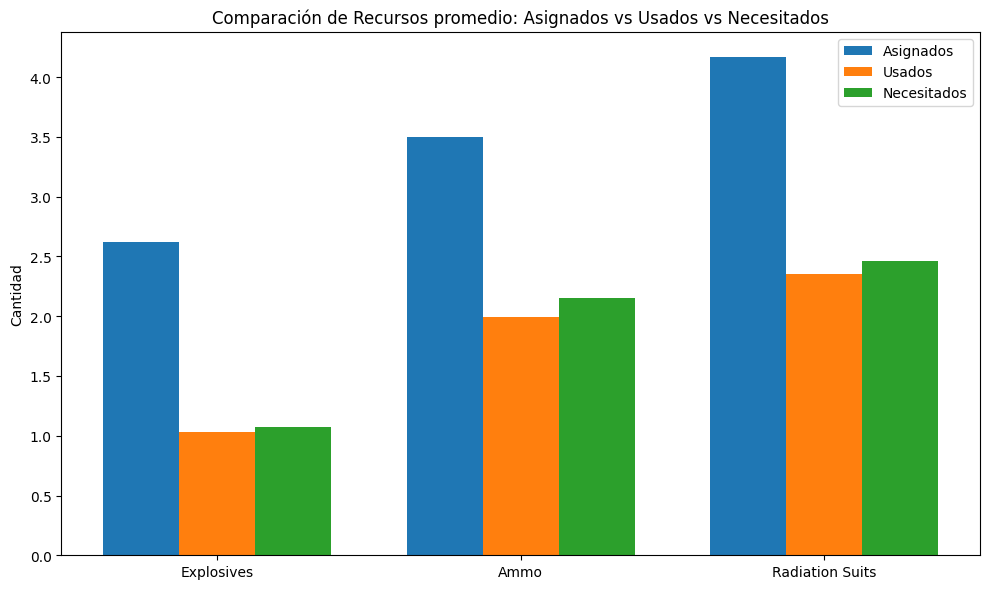

Estadísticas de uso de recursos:
              tipo  asignados  usados  necesitados  eficiencia
0       explosives      2.620   1.035        1.075       0.645
1             ammo      3.495   1.995        2.150       0.880
2  radiation_suits      4.170   2.350        2.460       0.830

Recurso más usado: radiation_suits
Recurso más necesitado: radiation_suits


In [8]:
# Analizar el uso de recursos
resource_types = list(resource_metrics['overall'].keys())
allocated = [resource_metrics['overall'][rt]['avg_allocated'] for rt in resource_types]
used = [resource_metrics['overall'][rt]['avg_used'] for rt in resource_types]
needed = [resource_metrics['overall'][rt]['avg_needed'] for rt in resource_types]

# Crear un gráfico comparativo
plt.figure(figsize=(10, 6))
x = range(len(resource_types))
width = 0.25

plt.bar([i - width for i in x], allocated, width, label='Asignados')
plt.bar(x, used, width, label='Usados')
plt.bar([i + width for i in x], needed, width, label='Necesitados')

plt.xticks(x, [rt.replace('_', ' ').title() for rt in resource_types])
plt.ylabel('Cantidad')
plt.title('Comparación de Recursos promedio: Asignados vs Usados vs Necesitados')
plt.legend()
plt.tight_layout()
plt.show()

# Análisis estadístico
resource_df = pd.DataFrame({
    'tipo': resource_types,
    'asignados': allocated,
    'usados': used,
    'necesitados': needed,
    'eficiencia': [resource_metrics['overall'][rt]['efficiency'] for rt in resource_types]
})

print("Estadísticas de uso de recursos:")
print(resource_df)
print("\nRecurso más usado:", resource_metrics['analysis']['most_used_resource'])
print("Recurso más necesitado:", resource_metrics['analysis']['most_needed_resource'])

# Hipótesis 4: Distribución uniforme de tamaños de ciudades

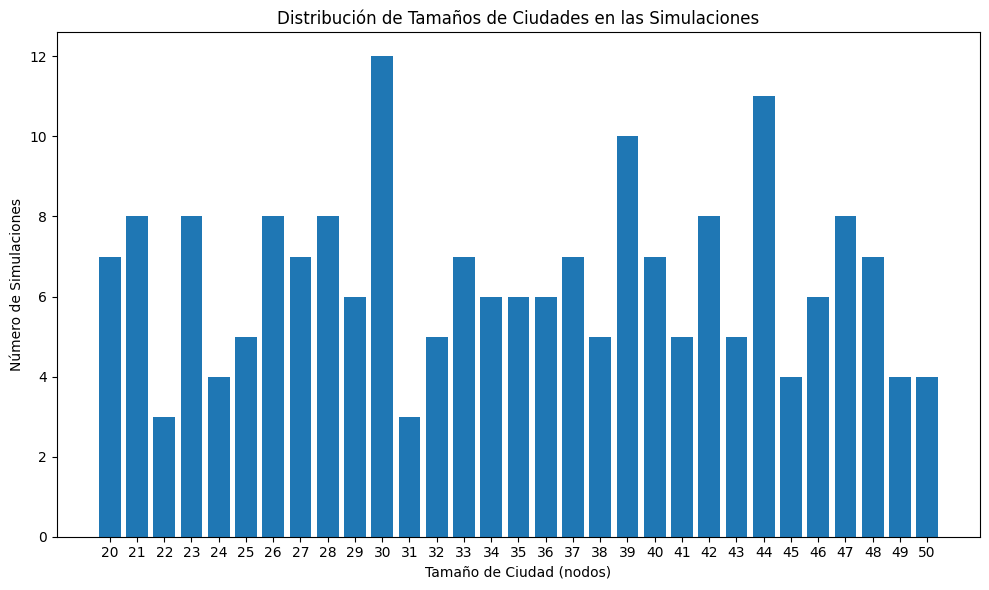

Test Chi-cuadrado para distribución uniforme: chi2=21.6500, p=0.8665
La distribución es estadísticamente uniforme (α=0.05)


In [9]:
# Extraer los tamaños de ciudades
city_sizes = list(core_metrics['by_city_size'].keys())
city_counts = {}
for size in city_sizes:
    city_counts[int(size)] = core_metrics['by_city_size'][size]['n_runs']

# Visualizar la distribución
plt.figure(figsize=(10, 6))
plt.bar(city_counts.keys(), city_counts.values())
plt.xlabel('Tamaño de Ciudad (nodos)')
plt.ylabel('Número de Simulaciones')
plt.title('Distribución de Tamaños de Ciudades en las Simulaciones')
plt.xticks(list(city_counts.keys()))
plt.tight_layout()
plt.show()

# Test chi-cuadrado para uniformidad
from scipy.stats import chisquare
expected = [sum(city_counts.values()) / len(city_counts)] * len(city_counts)
chi2, p = chisquare(list(city_counts.values()), expected)
print(f"Test Chi-cuadrado para distribución uniforme: chi2={chi2:.4f}, p={p:.4f}")
print(f"La distribución {'es' if p > 0.05 else 'no es'} estadísticamente uniforme (α=0.05)")

# Análisis adicional: Éxito por tamaño de ciudad

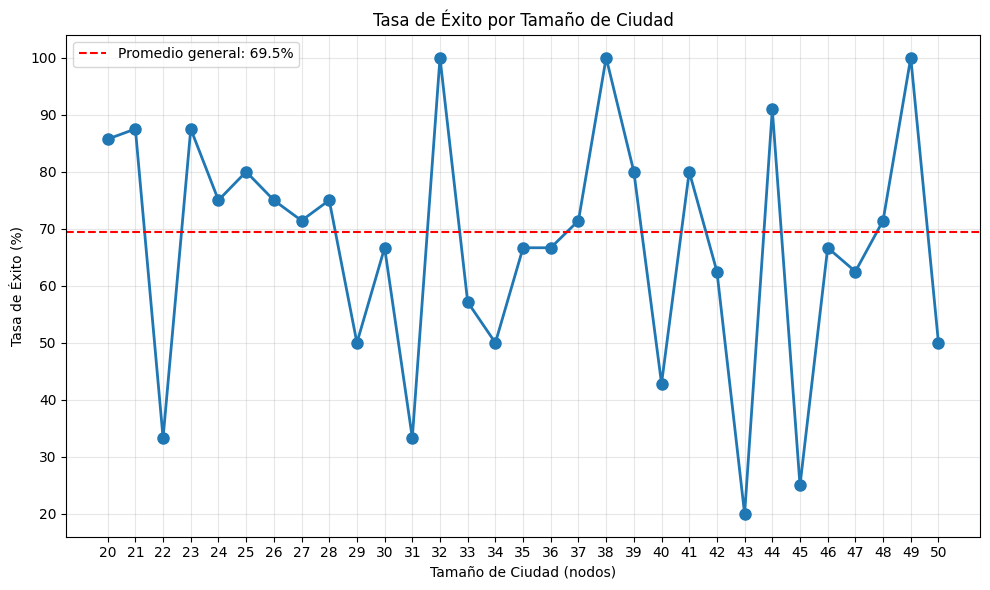

In [10]:
# Analizar tasa de éxito por tamaño de ciudad
sizes = []
success_rates = []

for size, metrics in core_metrics['by_city_size'].items():
    sizes.append(int(size))
    success_rates.append(metrics['success_rate'] * 100)

# Ordenar por tamaño
sorted_data = sorted(zip(sizes, success_rates))
sizes, success_rates = zip(*sorted_data)

plt.figure(figsize=(10, 6))
plt.plot(sizes, success_rates, 'o-', linewidth=2, markersize=8)
plt.axhline(y=core_metrics['overall_performance']['success_rate'] * 100, 
           color='r', linestyle='--', 
           label=f'Promedio general: {core_metrics["overall_performance"]["success_rate"]*100:.1f}%')
plt.xlabel('Tamaño de Ciudad (nodos)')
plt.ylabel('Tasa de Éxito (%)')
plt.title('Tasa de Éxito por Tamaño de Ciudad')
plt.xticks(sizes)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

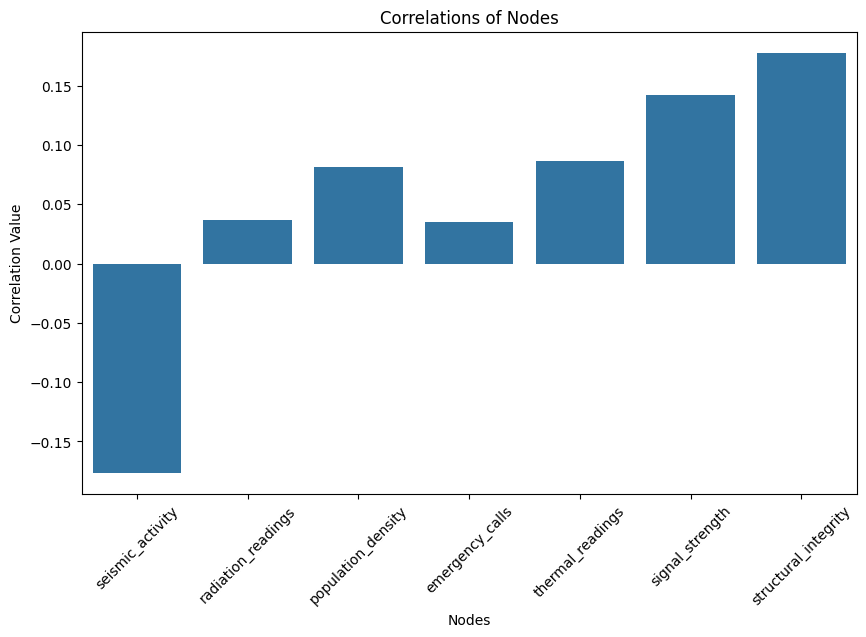

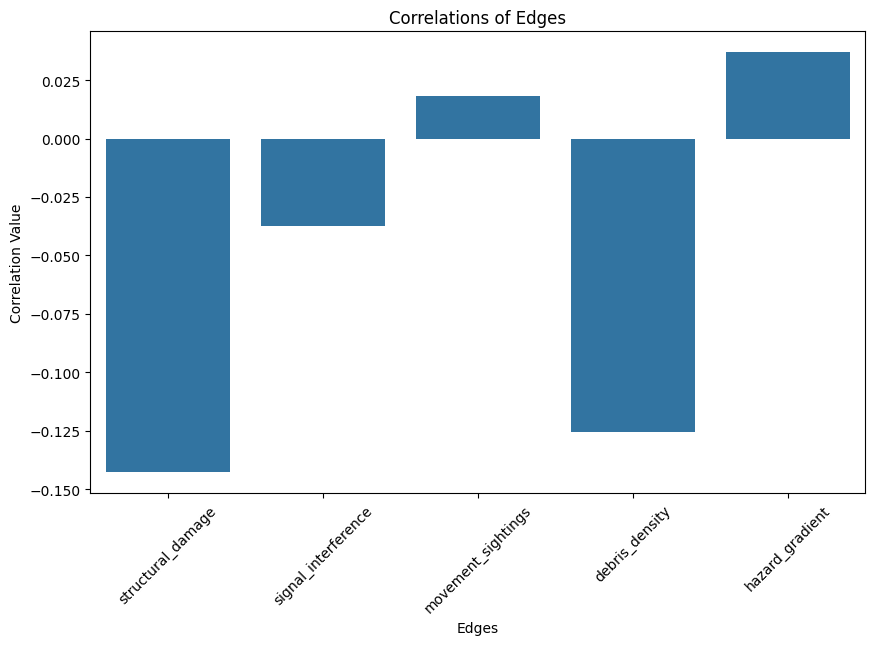

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import json

data= env_metrics

# Extraer los datos relevantes
overall_nodes = data['overall']['nodes']
overall_edges = data['overall']['edges']
city_sizes = data['by_city_size']
correlations_nodes = data['correlations']['nodes']
correlations_edges = data['correlations']['edges']



# Graficar las correlaciones de los nodos
plt.figure(figsize=(10, 6))
sns.barplot(x=list(correlations_nodes.keys()), y=list(correlations_nodes.values()))
plt.title('Correlations of Nodes')
plt.ylabel('Correlation Value')
plt.xlabel('Nodes')
plt.xticks(rotation=45)
plt.show()

# Graficar las correlaciones de las aristas
plt.figure(figsize=(10, 6))
sns.barplot(x=list(correlations_edges.keys()), y=list(correlations_edges.values()))
plt.title('Correlations of Edges')
plt.ylabel('Correlation Value')
plt.xlabel('Edges')
plt.xticks(rotation=45)
plt.show()



In [12]:
with open('/Users/jeronimo/Desktop/Jero/VS_Code/IA/graph_zombie_repo/data/policies/EvacuationPolicy/experiments/20250304_0942/raw_data.json', 'r') as f:
    raw_data = json.load(f)

# Print keys to understand structure
print("Keys in raw_data:", raw_data.keys())

Keys in raw_data: dict_keys(['runs', 'by_size'])


seismic_activity (Nodes) Statistics:
Mean: 0.4017
Median: 0.3649
Standard Deviation: 0.2850
Number of values: 6971

radiation_readings (Nodes) Statistics:
Mean: 0.4037
Median: 0.3819
Standard Deviation: 0.3045
Number of values: 6971

population_density (Nodes) Statistics:
Mean: 0.2217
Median: 0.2004
Standard Deviation: 0.1697
Number of values: 6971

emergency_calls (Nodes) Statistics:
Mean: 0.7385
Median: 0.8546
Standard Deviation: 0.3019
Number of values: 6971

thermal_readings (Nodes) Statistics:
Mean: 0.3910
Median: 0.3805
Standard Deviation: 0.1789
Number of values: 6971

signal_strength (Nodes) Statistics:
Mean: 0.6070
Median: 0.6174
Standard Deviation: 0.2255
Number of values: 6971

structural_integrity (Nodes) Statistics:
Mean: 0.6020
Median: 0.6371
Standard Deviation: 0.2849
Number of values: 6971

structural_damage (Edges) Statistics:
Mean: 0.4838
Median: 0.4274
Standard Deviation: 0.3600
Number of values: 13204

signal_interference (Edges) Statistics:
Mean: 0.3432
Median: 0.3

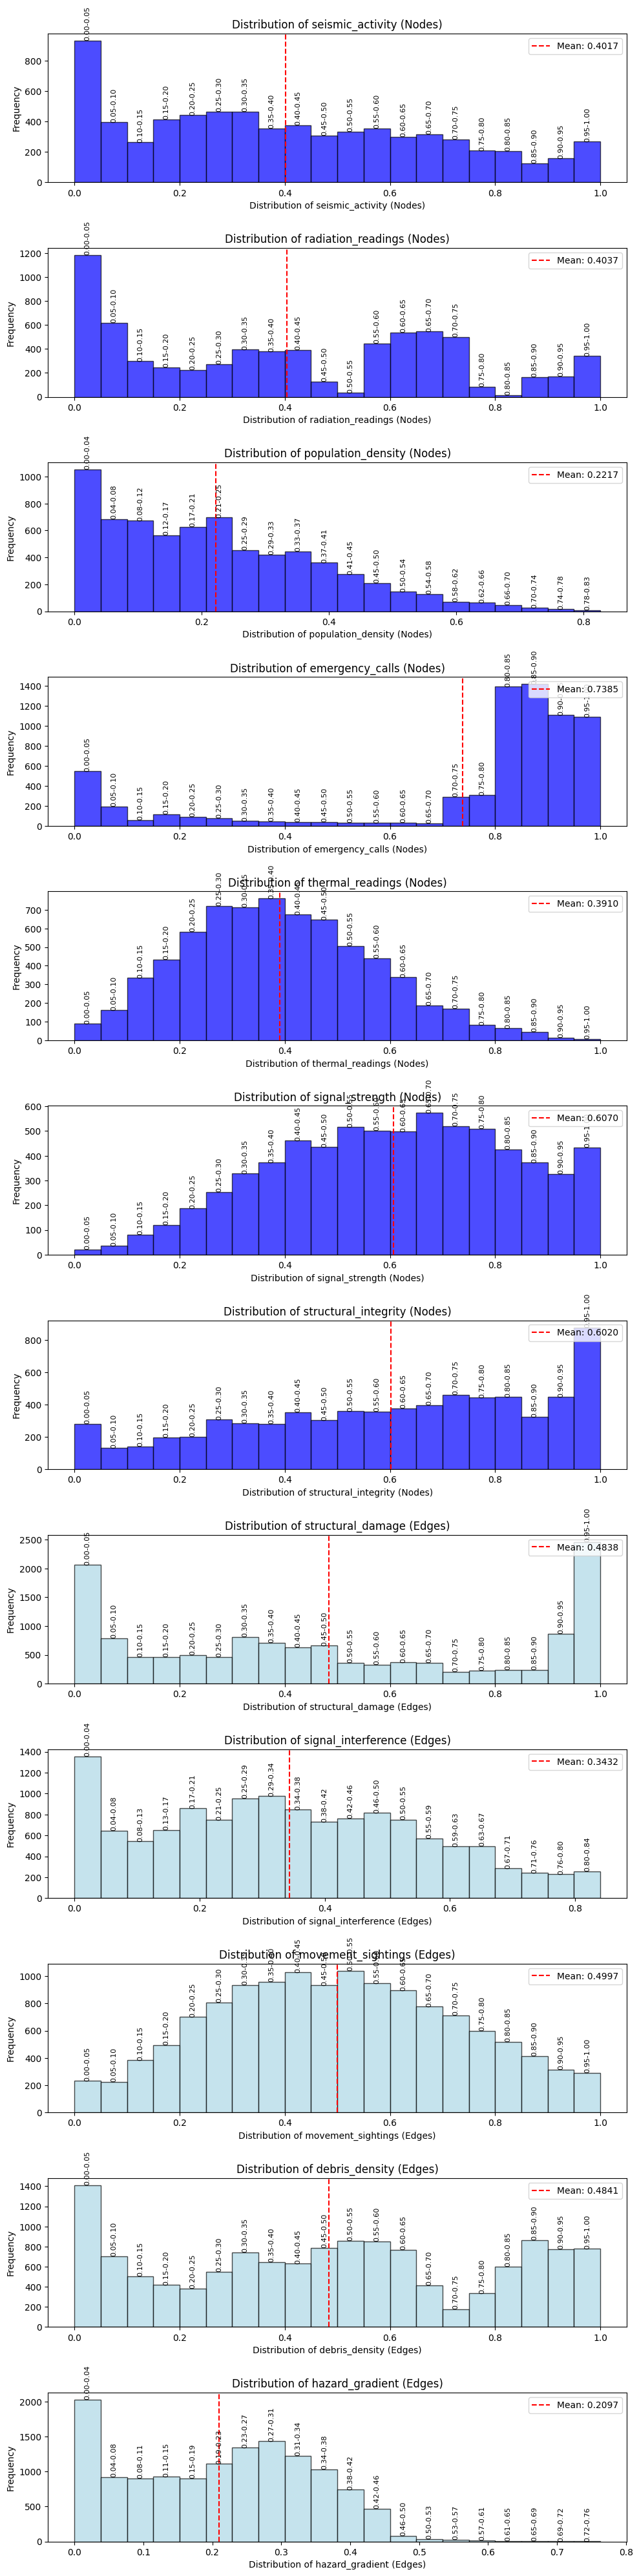

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the data
with open('/Users/jeronimo/Desktop/Jero/VS_Code/IA/graph_zombie_repo/data/policies/EvacuationPolicy/experiments/20250304_0959/raw_data.json', 'r') as f:
    raw_data = json.load(f)

# Extract all factors from nodes and edges
node_factors = ['seismic_activity', 'radiation_readings', 'population_density', 
                'emergency_calls', 'thermal_readings', 'signal_strength', 
                'structural_integrity']
edge_factors = ['structural_damage', 'signal_interference', 'movement_sightings', 
                'debris_density', 'hazard_gradient']

# Create a function to plot histograms
def plot_histograms(data, title, color, ax):
    # Calculate mean
    mean_value = np.mean(data)
    
    # Create histogram
    n, bins, patches = ax.hist(data, bins=20, edgecolor='black', color=color, alpha=0.7)
    
    # Add x-axis values on top of bars
    for i, rect in enumerate(patches):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                f'{bins[i]:.2f}-{bins[i+1]:.2f}', 
                ha='center', va='bottom', rotation=90, fontsize=8)
    
    # Add mean as a vertical line
    ax.axvline(x=mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.4f}')
    ax.legend(loc='upper right')
    
    ax.set_title(title)
    ax.set_xlabel(title)
    ax.set_ylabel('Frequency')

# Create a figure with subplots for each factor
fig, axes = plt.subplots(len(node_factors) + len(edge_factors), 1, figsize=(10, 40))

# Iterate through node factors
for i, factor in enumerate(node_factors):
    data = []
    for run in raw_data['runs']:
        for node in run['proxy_data']['nodes'].values():
            data.append(node[factor])
    
    # Plot histogram for node factor
    plot_histograms(data, f'Distribution of {factor} (Nodes)', 'blue', axes[i])
    
    # Print statistics
    print(f"{factor} (Nodes) Statistics:")
    print(f"Mean: {np.mean(data):.4f}")
    print(f"Median: {np.median(data):.4f}")
    print(f"Standard Deviation: {np.std(data):.4f}")
    print(f"Number of values: {len(data)}\n")

# Iterate through edge factors
for i, factor in enumerate(edge_factors):
    data = []
    for run in raw_data['runs']:
        for edge in run['proxy_data']['edges'].values():
            data.append(edge[factor])
    
    # Plot histogram for edge factor
    plot_histograms(data, f'Distribution of {factor} (Edges)', 'lightblue', axes[i + len(node_factors)])
    
    # Print statistics
    print(f"{factor} (Edges) Statistics:")
    print(f"Mean: {np.mean(data):.4f}")
    print(f"Median: {np.median(data):.4f}")
    print(f"Standard Deviation: {np.std(data):.4f}")
    print(f"Number of values: {len(data)}\n")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Intervalos Recomendados para Indicadores Proxy

| Indicador | Media | Intervalo Seguro | Justificación |
|-----------|-------|-----------------|---------------|
| **Actividad Sísmica** | 0.4017 | 0.00 - 0.35 | Valores en este rango indican terreno estable. El documento señala que "números cercanos a 0 suelen indicar terreno estable", mientras que valores más altos preceden a colapsos. |
| **Lecturas de Radiación** | 0.4037 | 0.00 - 0.45 | Rango donde los equipos de protección estándar son suficientes. La guía menciona que "las lecturas intermedias suelen indicar zonas donde los trajes de protección son suficientes". |
| **Densidad Poblacional** | 0.2217 | 0.00 - 0.40 | Concentración baja a moderada de actividad, reduciendo probabilidad de grandes grupos de infectados. La guía advierte que "lecturas altas a veces indican grandes concentraciones de infectados". |
| **Llamadas de Emergencia** | 0.7385 | 0.00 - 0.70 | Permite responder a emergencias genuinas evitando las situaciones más peligrosas. El documento indica que "las señales más intensas han coincidido con situaciones de peligro extremo". |
| **Lecturas Térmicas** | 0.3910 | 0.00 - 0.55 | Permite detectar actividad térmica normal y supervivientes, evitando patrones de infectados. La guía menciona que "los infectados generan patrones térmicos distintivos". |
| **Fuerza de Señal** | 0.6070 | 0.45 - 1.00 | Asegura comunicaciones confiables. La guía indica que "las lecturas intermedias suelen indicar zonas donde la comunicación es posible pero puede ser inestable". |
| **Integridad Estructural** | 0.6020 | 0.50 - 1.00 | Estructuras con suficiente estabilidad. La guía advierte sobre el riesgo en "zonas donde múltiples estructuras muestran lecturas bajas simultáneamente". |
| **Daño Estructural** | 0.4838 | 0.00 - 0.40 | Rutas con obstáculos manejables sin equipo especializado. El documento indica que valores altos representan "un bloqueo total que requiere explosivos". |
| **Interferencia de Señal** | 0.3432 | 0.00 - 0.45 | Comunicaciones relativamente claras y menor probabilidad de radiación alta. La guía menciona que "la interferencia tiende a aumentar cerca de zonas con alta radiación". |
| **Avistamientos de Movimiento** | 0.4997 | 0.00 - 0.65 | Actividad moderada, reduciendo riesgo de grandes grupos de infectados. El documento destaca que observadores pueden "distinguir entre patrones de movimiento de supervivientes y de infectados". |
| **Densidad de Escombros** | 0.4841 | 0.00 - 0.50 | Escombros manejables con equipamiento estándar. La guía indica que "los equipos de rescate usan estas lecturas para planificar qué herramientas llevar". |
| **Gradiente de Peligro** | 0.2097 | 0.00 - 0.30 | Condiciones ambientales relativamente estables. El documento destaca que "los cambios bruscos en las condiciones eran a menudo más peligrosos que las condiciones adversas constantes". |

*Nota: Estos intervalos representan las zonas de operación más seguras según los datos históricos y las descripciones en la guía. Como advierte el documento, "los equipos de rescate deben considerar estos indicadores como guías aproximadas, no como verdades absolutas."*